# ECON 5821 Final Project

Group menbers: Zhu Jiageng, Yang Yi, Yu Lian

Download and read Excel data from the given URL. Find and select the data for the 'Personal consumption expenditures' row, and try to convert it to floating point numbers. If there are NaN values, handle them as 0. Calculate the inflation rate.

In [1]:
import pandas as pd
import numpy as np

url = 'https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_training.xlsx'
data = pd.read_excel(url, header=None, engine='openpyxl')

# 找到'Personal consumption expenditures'所在的行
pce_row_index = data[data.iloc[:, 0] == '            Personal consumption expenditures'].index[0]

# 选择'Personal consumption expenditures'行的数据
pce = data.iloc[pce_row_index, 1:].values

# 尝试将数据类型转换为浮点数
try:
    pce = pce.astype(np.float64)
except ValueError:
    print("Cannot convert pce to float64. It may contain non-numeric values.")

# 检查是否存在NaN值
if np.isnan(pce).any():
    # 处理NaN值
    pce = np.nan_to_num(pce)

# 计算通胀率
inflation_rate = (np.log(pce[1:]) - np.log(pce[:-1])) * 12

print(inflation_rate)  # 打印计算出的通胀率

[ 0.01186435  0.00790306  0.02367799  0.00630625  0.03462525  0.02511939
  0.01723913  0.03128057  0.02886211  0.00778867  0.01400688 -0.00700139
  0.0124441   0.00699414  0.04342773  0.01237911  0.00541185  0.02162302
  0.02004369  0.00693041  0.01384882  0.04068451  0.00229878  0.00229834
  0.01071976 -0.00689017 -0.00689413  0.00689413  0.00535936  0.02599721
  0.00992524  0.01372911 -0.00076232  0.00076232  0.00304878  0.0228412
  0.03190481  0.01592065  0.01362948  0.00756525  0.00756048 -0.00680422
  0.0173809   0.05875718 -0.01202932  0.00827145 -0.004511    0.02929121
  0.01274562 -0.00974543 -0.00074998  0.01948417  0.02617884  0.02388506
  0.01639345 -0.00223415  0.0230662   0.01708503  0.01780196  0.02517432
  0.01699979  0.00738371  0.00885446  0.00147511  0.01695072  0.01545586
  0.00882299  0.01836042  0.00733631  0.01685651  0.01756419  0.01315629
  0.00511244  0.01532427  0.01894584  0.02690992  0.03482048  0.00868936
  0.00289505  0.00578801  0.00361609  0.02023     0.

Select the rows for the predictors and try to convert them to floating point numbers. Then, convert the predictors to log differences and remove the first column (because its predictor is NaN). Align the data.

In [2]:
# 选择预测因子的行
predictors = data.iloc[5:210, 1:]

# 尝试将数据类型转换为浮点数
try:
    predictors = predictors.astype(np.float64)
except ValueError:
    print("Cannot convert predictors to float64. They may contain non-numeric values.")

# 将预测因子转换为对数差分
predictors_diff = np.log(predictors).diff(axis=1) * 12

# 删除第一列，因为它的预测因子是NaN
predictors_diff = predictors_diff.iloc[:, 1:]

# 现在，predictors_diff中的预测因子已经转换为对数差分，并与因变量对齐
print(predictors_diff)

          2         3         4         5         6         7         8    \
5    0.000000  0.046192 -0.023074  0.046103  0.022985  0.000000 -0.022985   
6    0.000000  0.046179 -0.023067  0.046090  0.022979  0.000000 -0.022979   
7   -0.000740  0.045419 -0.024350  0.045339  0.022789  0.000000 -0.022421   
8    0.102295  0.143224  0.065531 -0.001037  0.107925  0.238206 -0.075327   
9    0.183173 -0.092427  0.272846  0.088048  0.262593  0.087764 -0.085506   
..        ...       ...       ...       ...       ...       ...       ...   
204 -0.240377 -0.203205 -0.216092 -0.228558 -0.240588  0.086479  0.022598   
205 -0.263600 -0.114120 -0.366564 -0.326284 -0.044585 -0.027799  0.027799   
206 -0.320230 -0.246931 -0.277206 -0.229242 -0.270741 -0.002182  0.046826   
207 -0.320276 -0.247079 -0.277331 -0.228846 -0.270040 -0.002906  0.046407   
208  0.065499  0.075967  0.084892  0.002685  0.106917  0.100696  0.050033   

          9         10        11   ...       723       724       725  \
5  

Define a function create_lagged_dataset to create a lagged dataset, transpose the predictors, and align the data for easier model training.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 创建滞后的数据集
def create_lagged_dataset(X, y, lag=1):
    X_lagged, y_lagged = [], []
    for i in range(lag, len(X)):
        X_lagged.append(X[i-lag:i].values.flatten())  # 获取NumPy数组表示并展平
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged)

# 转置predictors_diff，使每一行对应一个特征，每一列对应一个样本
predictors_diff = predictors_diff.T

1. AR：The code trains AutoRegressive models with different lags (1, 3, 12 months) on a time series dataset, calculates the Mean Squared Error for each model's predictions, and saves the trained models to disk.

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from joblib import dump
import numpy as np

# 创建滞后的数据集
X_lagged, y_lagged = create_lagged_dataset(predictors_diff, inflation_rate, max([1, 3, 12]))

# 定义训练集和测试集
train_size = len(y_lagged) - 12
X_train, X_test = X_lagged[:train_size], X_lagged[train_size:]
y_train, y_test = y_lagged[:train_size], y_lagged[train_size:]

for lag in [1, 3, 12]:
    # 定义模型，提供一个lags值
    model = AutoReg(y_train, lags=lag).fit()

    # 使用模型进行预测
    predictions = model.predict(start=len(y_train), end=len(y_train) + lag - 1)

    # 确保预测和实际值的长度相同
    if len(predictions) > len(y_test):
        predictions = predictions[:len(y_test)]
    elif len(predictions) < len(y_test):
        y_test = y_test[:len(predictions)]

    # 计算预测误差
    error = mean_squared_error(y_test, predictions)
    print(f'Prediction error for {lag}-month ahead: {error}')

    # 保存模型
    dump(model, f'auto_reg_model_{lag}.joblib')

Prediction error for 1-month ahead: 0.00018750643277681245
Prediction error for 3-month ahead: 0.00017942293653649076
Prediction error for 12-month ahead: 0.00016710074680933233


2. LASSO：The code trains LassoCV models with different lags (1, 3, 12 months) on a time series dataset, calculates the Mean Squared Error for each model's predictions, prints the best alpha parameter for each model, and saves the trained models to disk.

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump

# 创建时间序列交叉验证对象，增加折数以使用更多的数据进行训练
tscv = TimeSeriesSplit(n_splits=10)

# 创建LassoCV对象
model = LassoCV(cv=tscv, random_state=0)

# 在训练模型后保存模型
for lag in [1, 3, 12]:
    # 创建滞后的数据集
    X_lagged, y_lagged = create_lagged_dataset(predictors_diff, inflation_rate, lag)

    # 将数据分为训练集和测试集，测试集大小为12，对应未来12个月
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=12, shuffle=False)

    # 训练模型
    model.fit(X_train, y_train)

    # 保存模型
    dump(model, f'lasso_model_{lag}.joblib')

    # 打印最佳参数
    print(f'Best alpha for {lag}-month ahead: {model.alpha_}')

    # 使用最佳参数的模型进行预测
    predictions = model.predict(X_test) 

    # 计算预测误差
    error = mean_squared_error(y_test, predictions)

    print(f'Prediction error for {lag}-month ahead: {error}')

c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e-06, tolerance: 1.163e-06
  model = cd_fast.enet_coordinate_descent(
c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.759e-06, tolerance: 3.946e-06
  model = cd_fast.enet_coordinate_descent(
c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-05, toleranc

Best alpha for 1-month ahead: 5.0589060956950255e-05
Prediction error for 1-month ahead: 0.00015162299607888766


c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e-06, tolerance: 3.925e-06
  model = cd_fast.enet_coordinate_descent(
c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.107e-05, tolerance: 3.976e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\17718\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.075e-05, toleranc

Best alpha for 3-month ahead: 6.71019458312515e-05
Prediction error for 3-month ahead: 0.0002460038151027246
Best alpha for 12-month ahead: 6.313685209308287e-05
Prediction error for 12-month ahead: 0.0004487688406244708


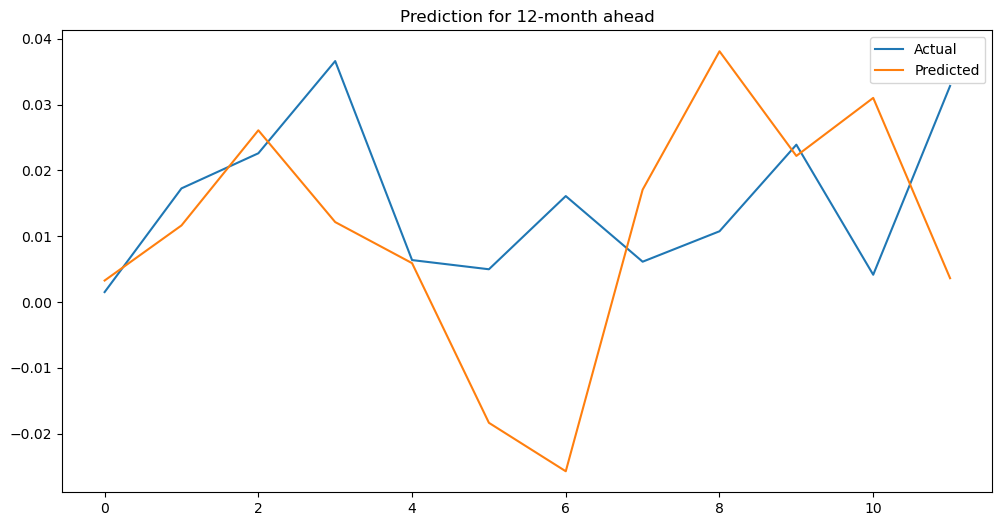

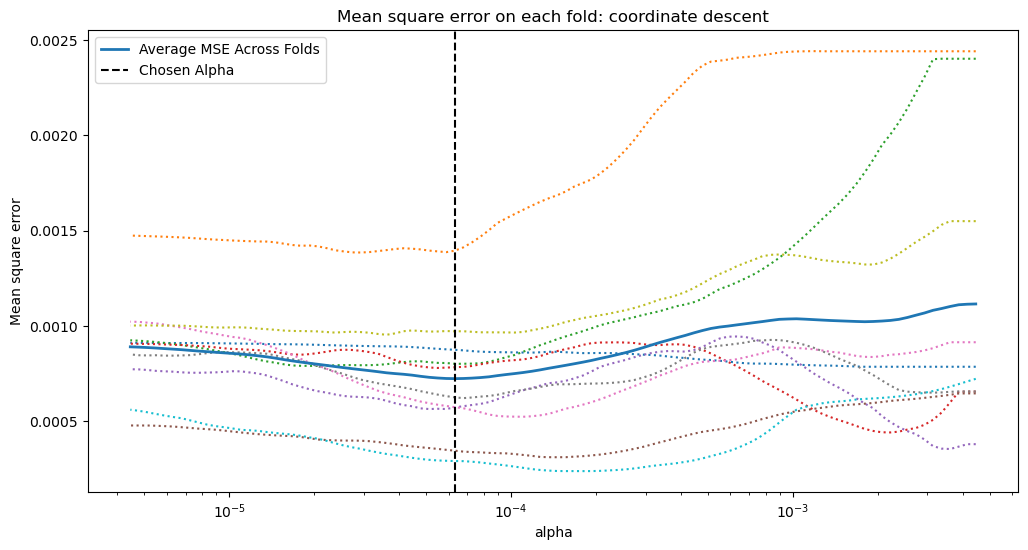

In [6]:
import matplotlib.pyplot as plt

# 绘制预测值与实际值的对比图
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), predictions, label='Predicted')
plt.title(f'Prediction for {lag}-month ahead')
plt.legend()
plt.show()

# 绘制模型的系数路径图
plt.figure(figsize=(12, 6))
plt.plot(model.alphas_, model.mse_path_, ':')
plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), label='Average MSE Across Folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k', label='Chosen Alpha')
plt.legend()
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')
plt.show()

3. Random Forest: The code trains RandomForestRegressor models with different lags (1, 3, 12 months) on a time series dataset using RandomizedSearchCV for hyperparameter tuning. It calculates the Mean Squared Error for each model's predictions, prints the best parameters for each model, and saves the trained models to disk.

In [7]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump

# 创建并训练模型
model = RandomForestRegressor(random_state=0)

# 定义要搜索的参数网格
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# 创建时间序列交叉验证对象
tscv = TimeSeriesSplit(n_splits=5)

# 创建随机搜索对象
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0)

# 在训练模型后保存模型
for lag in [1, 3, 12]:
    # 创建滞后的数据集
    X_lagged, y_lagged = create_lagged_dataset(predictors_diff, inflation_rate, lag)

    # 将数据分为训练集和测试集，测试集大小为12，对应未来12个月
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=12, shuffle=False)

    # 训练模型
    random_search.fit(X_train, y_train)

    # 保存模型
    dump(random_search.best_estimator_, f'random_forest_model_{lag}.joblib')

    # 打印最佳参数
    print(f'Best parameters for {lag}-month ahead: {random_search.best_params_}')

    # 使用最佳参数的模型进行预测
    predictions = random_search.predict(X_test) 

    # 计算预测误差
    error = mean_squared_error(y_test, predictions)

    print(f'Prediction error for {lag}-month ahead: {error}')

Best parameters for 1-month ahead: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Prediction error for 1-month ahead: 0.00015946054416193965
Best parameters for 3-month ahead: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Prediction error for 3-month ahead: 0.0001247195643060928
Best parameters for 12-month ahead: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Prediction error for 12-month ahead: 0.0001304846157738691


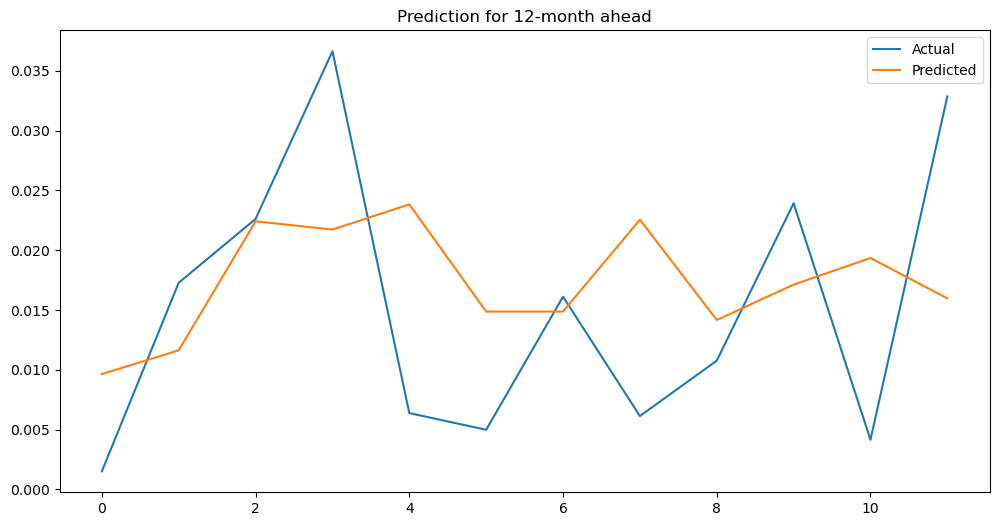

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制预测值与实际值的对比图
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), predictions, label='Predicted')
plt.title(f'Prediction for {lag}-month ahead')
plt.legend()
plt.show()

4. Gradient Boosting: The code trains LightGBM models with different lags (1, 3, 12 months) on a time series dataset using RandomizedSearchCV for hyperparameter tuning. It calculates the Mean Squared Error for each model's predictions, prints the best parameters for each model, and saves the trained models to disk.

In [9]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from joblib import dump
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 创建并训练模型
model = LGBMRegressor(random_state=0, force_col_wise=True)

# 定义要搜索的参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'num_leaves': [31, 62, 93, 124, 155],
    'min_child_samples': [20, 30, 40],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],  # L1 正则化
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]  # L2 正则化
}

# 创建时间序列交叉验证对象
tscv = TimeSeriesSplit(n_splits=5)

# 创建随机搜索对象
random_search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0)

# 在训练模型后保存模型
for lag in [1, 3, 12]:
    # 创建滞后的数据集
    X_lagged, y_lagged = create_lagged_dataset(predictors_diff, inflation_rate, lag)

    # 划分训练集和测试集
    train_size = len(X_lagged) - 12
    X_train, X_test = X_lagged[:train_size], X_lagged[train_size:]
    y_train, y_test = y_lagged[:train_size], y_lagged[train_size:]

    # 训练模型
    random_search.fit(X_train, y_train)

    # 保存模型
    dump(random_search.best_estimator_, f'lightgbm_model_{lag}.joblib')

    # 打印最佳参数
    print(f'Best parameters for {lag}-month ahead: {random_search.best_params_}')

    # 使用最佳参数的模型进行预测
    predictions = random_search.predict(X_test)

    # 计算预测误差
    error = mean_squared_error(y_test, predictions)

    print(f'Prediction error for {lag}-month ahead: {error}')

[LightGBM] [Info] Total Bins 47309
[LightGBM] [Info] Number of data points in the train set: 718, number of used features: 204
[LightGBM] [Info] Start training from score 0.031954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

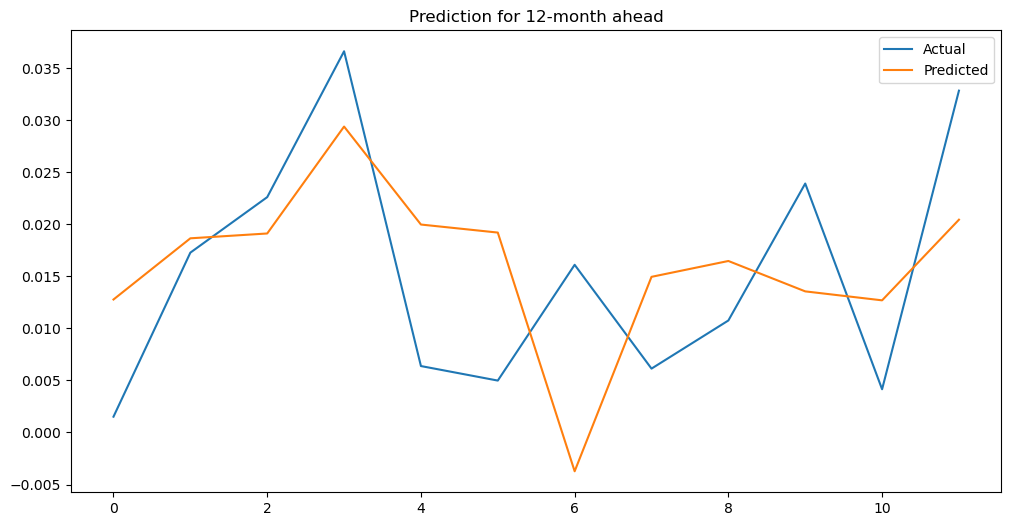

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制预测值与实际值的对比图
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), predictions, label='Predicted')
plt.title(f'Prediction for {lag}-month ahead')
plt.legend()
plt.show()